# Densified Model for Shoal and Waller Creek Watersheds 

Modified from [Dr. Matt Bartos](https://github.com/mdbartos) code ["run_densified_model_with_forcings.ipynb"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/notebooks/run_densified_model_with_forcings.ipynb) and ["run_model_collection_with_da.ipynb"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/notebooks/run_model_collection_with_da.ipynb) located in [cuahsi-summer-institute-2025](https://github.com/future-water/cuahsi-summer-institute-2025/tree/main) repository. 

Modifications completed by [Victor Oladoja](https://github.com/oladojavictor) and [Megan Vardaman](https://github.com/Megan-Verf) as part of [2025 Water Prediction Innovators Summer Institute Program](https://www.cuahsi.org/summer-institute). 

Team Name: DensiFIMcation 

Members: Victor Oladoja, Alex Simpson, Megan Vardaman

# Import modules

In [422]:
import sys
sys.path.append('../../tx-fast-hydrology')

In [423]:
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Define region and time period of interest 

Assumes model has already been partitioned into submodel sections (see ["subset_waller_and_shoal_densified.ipynb"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/notebooks/subset_waller_and_shoal_densified.ipynb)) and that NWM output data has already been downloaded and converted to .hdf for the selected dates (see ["nwm_data_loader.py"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/utils/nwm_data_loader.py) and ["rewrite_h5_files.py"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/utils/rewrite_h5_files.py)). 

# Select dates

In [785]:
# Define time period 
startdate = '20250704'
enddate = '20250708'

# startdate = '20220822'
# enddate = '20220824'

startdate_string = format(pd.to_datetime(startdate, format = '%Y%m%d'), '%Y-%m-%d')
enddate_string = format(pd.to_datetime(enddate, format = '%Y%m%d'), '%Y-%m-%d')

# Date range to load
date_list = pd.date_range(startdate, enddate, freq='h', tz='utc')[:-1]

# Define path for NWM forcings
forcing_path = '../../densifimcation_shared/forcing/'+ startdate +'_event'

# Load model collection

In [786]:
# Define model file input path
# input_path = '../../DensiFIMcation/data/shoal_waller_nwm_partitioned.json'
input_path = '../../DensiFIMcation/data/shoal_waller_less_densified_partitioned.json'

# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

In [787]:
if input_path == '../../DensiFIMcation/data/shoal_waller_nwm_partitioned.json': 
    # Define watershed 
    ws = 'shoal_waller_nwm' 
    ws_string = 'Shoal and Waller Creek (NWM)' 
    mtd = '120s'
elif input_path == '../../DensiFIMcation/data/shoal_waller_less_densified_partitioned.json': 
    # Define watershed 
    ws = 'shoal_waller_den' 
    ws_string = 'Shoal and Waller Creek (densified)' 
    mtd = '20s'
elif input_path == '../../densifimcation_shared/data/shoal_densified.json': 
    # Define watershed 
    ws = 'shoal_more_den' 
    ws_string = 'Shoal Creek (more densified)' 

Text(0.5, 1.0, 'NWM')

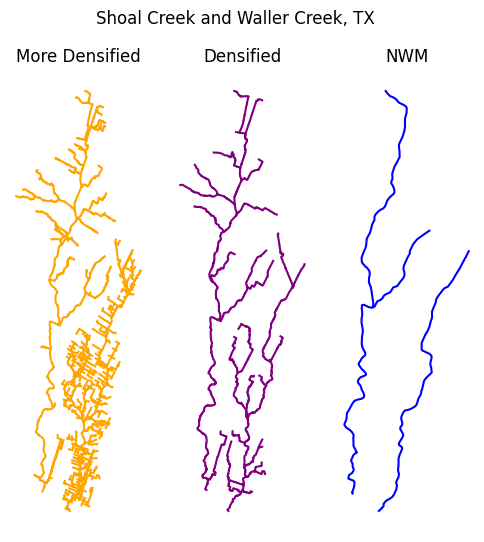

In [788]:
# Plot Shoal and Waller Creek
# Read dumped model files
waller_densified = ModelCollection.from_file('../../densifimcation_shared/data/waller_densified.json')
shoal_densified = ModelCollection.from_file('../../densifimcation_shared/data/shoal_densified.json')
shoal_less_densified = ModelCollection.from_file('../../DensiFIMcation/data/shoal_waller_less_densified_partitioned.json')
shoal_nwm = ModelCollection.from_file('../../DensiFIMcation/data/shoal_waller_nwm_partitioned.json')

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(6,6))
for model_name, model in waller_densified.models.items():
    model.plot(ax=ax, c='orange')
for model_name, model in shoal_densified.models.items():
    model.plot(ax=ax, c='orange')
for model_name, model in shoal_less_densified.models.items():
    model.plot(ax=ax1, c='purple')
for model_name, model in shoal_nwm.models.items():
    model.plot(ax=ax2, c='blue')
ax.axis('off')
ax1.axis('off')
ax2.axis('off')

plt.suptitle('Shoal Creek and Waller Creek, TX')
ax.set_title('More Densified')
ax1.set_title('Densified')
ax2.set_title('NWM')

# Create model inputs

### Load NWM forcings

In [789]:
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

### Optional: Reset Model Timedelta

In [790]:
# IMPLICATIONS OF THIS PROCESS ON MODEL RESULTS ARE UNCERTAIN 
if input_path == '../../DensiFIMcation/data/shoal_waller_less_densified_partitioned.json': 
    for model in model_collection.models.values():
        # change the timestep
        model.timedelta = pd.to_timedelta(mtd)
        model.compute_muskingum_coeffs()
        #print(model.timedelta)
else: 
    for model in model_collection.models.values():
        print(model.timedelta.seconds)

### Create inputs to model based on forcings

In [791]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

a = []
# Fill input table with forcings for each reach
if input_path == '../../DensiFIMcation/data/shoal_waller_nwm_partitioned.json':                                        

    # Fill input table with forcings for each reach
    for col in inputs.columns:
        if col in forcing.columns:
            inputs[col] = forcing[col]


elif input_path == '../../DensiFIMcation/data/shoal_waller_less_densified_partitioned.json':

    store = pd.HDFStore('../../densifimcation_shared/data/area_fractions_shoalwaller.h5', 'r')
    hdf_keys = store.keys()
    store.close()
    for key in hdf_keys:
        comid = key.split('__')[-1]        
        area_ratios = pd.read_hdf(f'../../densifimcation_shared/data/area_fractions_shoalwaller.h5', key=key)
        for reach_id in area_ratios.index:
            if comid in forcing.columns:
                runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
                reach_id_str = str(reach_id)
                a.append(reach_id_str)
                if reach_id_str in inputs.columns:
                    inputs[reach_id_str] += runoff_proportion

# NOT NEEDED FOR SHOAL AND WALLER CREEK AREAS -- NO UPSTREAM INPUTS 
# Add inflow to upstream boundary reaches
# upstream_inputs = {
#     '5779305' : '5781161',
#     '5785187' : '5785899',
#     '5786029' : '5785351'
# }
# for downstream_reach, upstream_reach in upstream_inputs.items():
#     inputs[downstream_reach] += streamflow[upstream_reach]

In [792]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
print('Model timedelta is ' + str(dt) + ' seconds') 
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

Model timedelta is 20 seconds


# Gather gage measurements for event period

### From USGS DataRetrieval Package

In [793]:
# Load table of mappings from USGS Gage IDs to NWM COMIDs
if input_path == '../../DensiFIMcation/data/shoal_waller_nwm_partitioned.json':
    usgs_to_densified_reach_df = pd.read_csv('../../densifimcation_shared/data/usgs_to_comid.csv', index_col=0) 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[['gage_id','comid']].reset_index(drop=True).dropna().reset_index(drop=True)
    usgs_to_densified_reach_df['gage_id'] = usgs_to_densified_reach_df['gage_id'].astype(int).astype(str)
    usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['comid'].astype(int).astype(str)
    # Filter 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]
    # Prepare gage IDs for USGS dataretrieval 
    sites = usgs_to_densified_reach_df.gage_id.dropna().astype(int).astype(str).reset_index(drop = True)
    site_ids = []
    for i in sites: 
        site_ids.append(i.zfill(8)) # add leading zeros to gage IDs 
    print('Number of gages: ' + str(len(site_ids)))

    # Get site info 
    TCsites = nwis.what_sites(sites = site_ids, startDT=startdate_string, endDT=enddate_string, parameterCd="00060")
    # print(TCsites[0].head())

    # Convert to series 
    usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['gage_id'].values)
    print(usgs_to_densified_reach)
    # usgs_to_densified_reach = usgs_to_densified_reach.drop(['8156675', '8156800', '8156910']) # drop gage with missing data 

elif input_path == '../../DensiFIMcation/data/shoal_waller_less_densified_partitioned.json':
    usgs_to_densified_reach_df = pd.read_csv('../../DensiFIMcation/data/NWPSGages_Shoal_Waller_to_Less_Densified.csv', index_col=0) 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[['usgs_id','HydroID']].reset_index(drop=True).dropna().reset_index(drop=True)
    usgs_to_densified_reach_df['usgs_id'] = usgs_to_densified_reach_df['usgs_id'].astype(int).astype(str)
    usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['HydroID'].astype(int).astype(str)
    # Filter 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]
    # Prepare gage IDs for USGS dataretrieval 
    sites = usgs_to_densified_reach_df.usgs_id.dropna().astype(int).astype(str).reset_index(drop = True)
    # sites = usgs_to_comid.usgs_id.dropna().astype(int).astype(str).reset_index(drop = True)

    # Convert to series 
    usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['usgs_id'].values)
    usgs_to_densified_reach = usgs_to_densified_reach.drop('8157560') # drop gage with missing data ['8157560']
    usgs_to_densified_reach = usgs_to_densified_reach.drop('8157540') # drop gage that appears to be faulty 
    # print('Final number of gages: ' + str(len(usgs_to_densified_reach)))

    site_ids = []
    for i in usgs_to_densified_reach.index: 
        site_ids.append(i.zfill(8)) # add leading zeros to gage IDs 
    print('Number of gages: ' + str(len(site_ids)))

    # Get site info 
    TCsites = nwis.what_sites(sites = site_ids, startDT=startdate_string, endDT=enddate_string, parameterCd="00060")
    print(TCsites[0].head())

    # usgs_to_densified_reach = usgs_to_densified_reach.drop(['8156800', '8156675', '8157560', '8156910']) # drop gage with missing data 



Number of gages: 3
  agency_cd   site_no                            station_nm site_tp_cd  \
0      USGS  08156675  Shoal Ck at Silverway Dr, Austin, TX         ST   
1      USGS  08156800     Shoal Ck at W 12th St, Austin, TX         ST   
2      USGS  08156910  Waller Ck at Koenig Lane, Austin, TX         ST   

   dec_lat_va  dec_long_va coord_acy_cd dec_coord_datum_cd  alt_va  \
0   30.354167   -97.738889            S              NAD83  672.72   
1   30.276598   -97.750305            F              NAD83  455.45   
2   30.322778   -97.722778            S              NAD83  644.60   

   alt_acy_va alt_datum_cd    huc_cd                    geometry  
0        0.24       NAVD88  12090205  POINT (-97.73889 30.35417)  
1        0.22       NAVD88  12090205   POINT (-97.75031 30.2766)  
2        0.16       NAVD88  12090205  POINT (-97.72278 30.32278)  


20250704
20250708
08156675
08156910
08156800


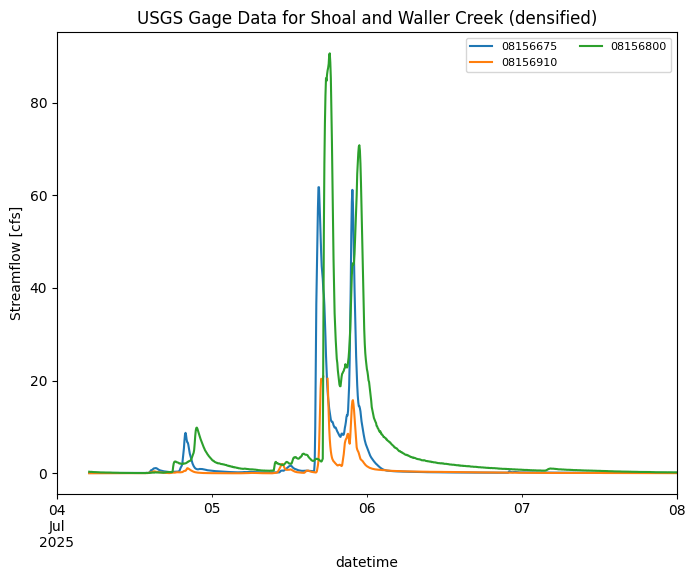

In [794]:
# Restructure data for h5 file 
eventdata = [] 
print(startdate)
print(enddate)

for i in list(set(site_ids)): 
    print(i)
    # fig, ax = plt.subplots()
    df = nwis.get_iv(sites=i, start=startdate_string, end=enddate_string, parameterCd='00060')
    df = pd.DataFrame(df[0])
    # print(df.columns)
    if len(df.columns) == 3 and len(df) > 0: 
        df.columns = ['site_no', '00060', 'sensor_cd']
        # print(df.sensor_cd)
        # print(df.columns)
        # ax.plot(df.index, df['00060']) #df['00060_primary sensor'])
        df1 = pd.DataFrame(df['00060'])
        df1.columns = [i]
        eventdata.append(df1)
    elif len(df.columns) > 3 and len(df) > 0: 
        df = df.iloc[:,:3]
        df.columns = ['site_no', '00060', 'sensor_cd']
        # print(df.columns)
        # ax.plot(df.index, df['00060']) #df['00060_primary sensor'])
        df1 = pd.DataFrame(df['00060'])
        df1.columns = [i]
        eventdata.append(df1)
        # ax.plot(df.index, df.iloc[:,1])
        # print(i)
        # print(df.sensor_cd)
        # print(df)
        # df1 = pd.DataFrame(df.iloc[:,1])
    else: 
        print('No data available for ' + str(i) + '! Record length = ' + str(len(df)))
    # plt.suptitle(i)
    # plt.show()

# Concatenate event data 
df2 = (pd.concat(eventdata, axis = 1))

# Convert cfs to cms 
df3 = df2*0.02831683199881

# Plot data 
df3.plot(figsize = (8,6))
plt.title('USGS Gage Data for ' + ws_string)
plt.ylabel('Streamflow [cfs]')
plt.legend(ncol = 2, loc = 'upper right', prop = {'size' : 8})
plt.xlim(startdate, enddate)

# Export data to hdf 
df3.loc[:, ~df3.columns.duplicated()].to_hdf('../../densifimcation_shared/data/gage_data_usgs/gages_usgs_'+ startdate +'_to_'+ enddate +'_' + ws + '.h5', key = 'usgs', mode = 'w')

#### Load USGS dataretrieval output

In [795]:
# Load table of USGS gage measurements
# measurements = pd.read_hdf('../../cuahsi-summer-institute-2025/data/gages.h5', key='usgs') # Original file from Matt Bartos 
measurements = pd.read_hdf('../../densifimcation_shared/data/gage_data_usgs/gages_usgs_' + startdate + '_to_' + enddate + '_' + ws + '.h5', key = 'usgs') # New file created from dataretrieval 
measurements.columns = measurements.columns.astype(int).astype(str)

# Filter measurements to those with associated COMIDs
measurements = measurements[usgs_to_densified_reach.index]
measurements.columns = measurements.columns.map(usgs_to_densified_reach)
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]


In [796]:

for i in measurements.columns: 
    # print((measurements[[i]].isna().any()).iloc[0])
    if measurements[[i]].isna().any().iloc[0] == True: 
        if measurements[[i]].isna().sum().iloc[0] > 10: 
            pass 
        else: 
            measurements[[i]] = measurements[[i]].interpolate(method = 'nearest')
        
measurements = measurements.dropna(axis=1)
# print(measurements[[i]].isna().any().iloc[0])

In [797]:

measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()
print(measurements)


                               3688      3621      3647
datetime                                               
2025-07-04 05:00:00+00:00  0.356792  0.077022  0.033414
2025-07-04 05:00:20+00:00  0.355471  0.077022  0.033282
2025-07-04 05:00:40+00:00  0.354149  0.077022  0.033150
2025-07-04 05:01:00+00:00  0.352828  0.077022  0.033017
2025-07-04 05:01:20+00:00  0.351506  0.077022  0.032885
...                             ...       ...       ...
2025-07-07 22:58:40+00:00  0.226554  0.101941  0.057483
2025-07-07 22:59:00+00:00  0.225629  0.101941  0.057483
2025-07-07 22:59:20+00:00  0.224704  0.101941  0.057483
2025-07-07 22:59:40+00:00  0.223778  0.101941  0.057483
2025-07-07 23:00:00+00:00  0.222853  0.101941  0.057483

[16201 rows x 3 columns]


#### Load original gages file provided by Matt Bartos (optional: alternative to USGS dataretrival method) 

In [798]:
# # Load table of mappings from USGS Gage IDs to NWM COMIDs
# usgs_to_densified_reach = pd.read_csv('../../cuahsi-summer-institute-2025/data/usgs_reach_id_densified.csv', index_col=0) 
# usgs_to_densified_reach = usgs_to_densified_reach[['usgs_id','reach_id']].reset_index(drop=True).dropna().reset_index(drop=True)
# usgs_to_densified_reach['usgs_id'] = usgs_to_densified_reach['usgs_id'].astype(int).astype(str)
# usgs_to_densified_reach['reach_id'] = usgs_to_densified_reach['reach_id'].astype(int).astype(str)
# # Filter 
# usgs_to_densified_reach = usgs_to_densified_reach[usgs_to_densified_reach['reach_id'].isin(input_columns)]
# usgs_to_densified_reach = pd.Series(usgs_to_densified_reach['reach_id'].values, index=usgs_to_densified_reach['usgs_id'].values)
# # usgs_to_densified_reach.drop(['8154900', '8154500'], inplace=True)


# # Load table of USGS gage measurements
# measurements = pd.read_hdf('../../cuahsi-summer-institute-2025/data/gages.h5', key='usgs')
# measurements.columns = measurements.columns.astype(int).astype(str)
# measurements = measurements[usgs_to_densified_reach.index]
# measurements.columns = measurements.columns.map(usgs_to_densified_reach)
# measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
# measurements = measurements.dropna(axis=1)
# measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
# measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
# measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()

# Set up Kalman Filter

In [799]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        # Q_cov = 0.1 * np.eye(model.n) # how much confindence in the model vs measurements...if the Q_cov is small, we are trust the model
        Q_cov = 1. * np.eye(model.n) # how much confindence in the model vs measurements...if the Q_cov is small, we are trust the model
        # Measurement noise covariance matrix
        # R_cov = 0.1 * np.eye(basin_measurements.shape[1])
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Prepare and execute simulation with Data Assimilation (DA)

### Prepare model for simulation

In [800]:
# # FOR PARTITIONED MODEL 
# # Add downstream boundaries to model
# for model in model_collection.models.values():
#     outlet = model.startnodes[model.startnodes == model.endnodes].item()
#     model.set_transmissive_boundary(outlet)

# # Set starting time of each model to just before start of forcings
# timedelta = pd.to_timedelta(dt, unit='s')
# for model_name, model in model_collection.models.items():
#     model.datetime = inputs.index[0] - timedelta

# # Set up simulation
# simulation = AsyncSimulation(model_collection, inputs)

In [801]:
# FOR NON-PARTITIONED MODEL 
# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [802]:
starttime = datetime.datetime.now()
# Simulate models
outputs_da1 = await simulation.simulate()
endtime = datetime.datetime.now()
# Collect outputs into a single table
outputs_da = pd.concat([series for series in outputs_da1.values()], axis=1)
print(f"the code took {endtime-starttime} to run")

the code took 0:00:26.862374 to run


# Test Forecast Approach 
Based on code prepared by Jeil Oh 

In [803]:
# # Required NWM variables
# nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']

# # Loop through HDF5 files and load forcings into memory
# streamflows = []
# runoffs = []
# buckets = []
# for date in date_list:
#     print(date)
#     date_str = date.strftime('%Y%m%d%H')
#     streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')
#     runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qSfcLatRunoff')
#     bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qBucket')
#     streamflows.append(streamflow)
#     runoffs.append(runoff)
#     buckets.append(bucket)
# # Concatenate all forcings into single dataframe
# streamflow = pd.concat(streamflows)
# runoff = pd.concat(runoffs)
# bucket = pd.concat(buckets)
# # Lateral inflow at each reach is equal to runoff plus bucket recharge
# forcing = runoff + bucket

# # Ensure no duplicate entries
# forcing = forcing.groupby(level=0).mean()
# streamflow = streamflow.groupby(level=0).mean()

# # Format column types
# forcing.columns = forcing.columns.astype(str)
# streamflow.columns = forcing.columns.astype(str)

In [804]:
# # Create input table with lateral overflow into each modeled reach
# input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
#                                                     in model_collection.models.values()]))
# input_index = forcing.index.copy()
# inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# # Fill input table with forcings for each reach
# store = pd.HDFStore('../../cuahsi-summer-institute-2025/data/area_fractions.h5', 'r')
# hdf_keys = store.keys()
# store.close()
# for key in hdf_keys:
#     comid = key.split('__')[-1]
#     area_ratios = pd.read_hdf(f'../../cuahsi-summer-institute-2025/data/area_fractions.h5', key=key)
#     for reach_id in area_ratios.index:
#         if comid in forcing.columns:
#             runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
#             reach_id_str = str(reach_id)
#             if reach_id_str in inputs.columns:
#                 inputs[reach_id_str] += runoff_proportion

# # NOT NEEDED FOR SHOAL AND WALLER CREEK AREAS -- NO UPSTREAM INPUTS 
# # Add inflow to upstream boundary reaches
# # upstream_inputs = {
# #     '5779305' : '5781161',
# #     '5785187' : '5785899',
# #     '5786029' : '5785351'
# # }
# # for downstream_reach, upstream_reach in upstream_inputs.items():
# #     inputs[downstream_reach] += streamflow[upstream_reach]

In [805]:
# # Resample forcing input table to frequency of model timestep
# dt = model_collection.timedelta.seconds
# print(dt)
# inputs = inputs.resample(f'{dt}s').mean()
# inputs = inputs.interpolate().bfill().ffill()
# assert not inputs.isnull().any().any()

In [806]:
# for date in date_list:
#     date_str = date.strftime('%Y%m%d%H')
#     print(date)
#     if hasattr(model, 'callbacks') and 'kf' in model.callbacks:
#             measurement_timestep = date
#             measurements_columns = model.callbacks['kf'].measurements.columns
#             print(model.callbacks['kf'].measurements)
#             model.callbacks['kf'].measurements = basin_measurements.loc[[measurement_timestep], measurements_columns]
        
#     for model in model_collection.models.values():
#         outlet = model.startnodes[model.startnodes == model.endnodes].item()
#         model.set_transmissive_boundary(outlet)

#     timedelta = pd.to_timedelta(dt, unit='s')
#     for model_name, model in model_collection.models.items():
#         model.datetime = inputs.index[0] - pd.to_timedelta('1h')

#     simulation = AsyncSimulation(model_collection, inputs)
#     outputs = await simulation.simulate()
#     all_outputs_da[date_str] = pd.concat([series for series in outputs.values()], axis=1)

In [807]:
# def load_nwm_data(forcing_path, date):
#     date_str = date.strftime('%Y%m%d%H')
#     streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')
#     runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qSfcLatRunoff')
#     bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qBucket')


#     forcing = runoff + bucket
#     return streamflow, forcing

In [808]:
# all_outputs_da = {}
# for date in date_list:
#     date_str = date.strftime('%Y%m%d%H')
#     model_collection.load_states()
    
#     streamflow, forcing = load_nwm_data(forcing_path, date)
#     forcing.columns = forcing.columns.astype(str)
#     streamflow.columns = forcing.columns.astype(str)
#     inputs = forcing

#     input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
#                                                     in model_collection.models.values()]))
#     input_index = forcing.index.copy()
#     inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

#     # Fill input table with forcings for each reach
#     for col in inputs.columns:
#         if col in forcing.columns:
#             inputs[col] = forcing[col]

#     # # Add inflow to upstream boundary reaches
#     # upstream_inputs = {
#     #     '5779305' : '5781161',
#     #     '5785187' : '5785899',
#     #     '5786029' : '5785351'
#     # }
#     # for downstream_reach, upstream_reach in upstream_inputs.items():
#     #     inputs[downstream_reach] += streamflow[upstream_reach]

#     inputs.columns = inputs.columns.astype(str)
#     dt = model_collection.timedelta.seconds
#     inputs = inputs.resample(f'{dt}s').mean()
#     inputs = inputs.interpolate().bfill().ffill()

#     if hasattr(model, 'callbacks') and 'kf' in model.callbacks:
#         measurement_timestep = date
#         measurements_columns = model.callbacks['kf'].measurements.columns
#         model.callbacks['kf'].measurements = basin_measurements.loc[[measurement_timestep], measurements_columns]
    
#     for model in model_collection.models.values():
#         outlet = model.startnodes[model.startnodes == model.endnodes].item()
#         model.set_transmissive_boundary(outlet)

#     timedelta = pd.to_timedelta(dt, unit='s')
#     for model_name, model in model_collection.models.items():
#         model.datetime = inputs.index[0] - pd.to_timedelta('1h')

#     simulation = AsyncSimulation(model_collection, inputs)
#     outputs = await simulation.simulate()
#     all_outputs_da[date_str] = pd.concat([series for series in outputs.values()], axis=1)

# Compare results

### Run model with no data assimilation (NODA)

In [809]:
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

for model in model_collection.models.values():
    # change the timestep
    model.timedelta = pd.to_timedelta(mtd)
    model.compute_muskingum_coeffs()
    #print(model.timedelta)

# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

starttime = datetime.datetime.now()

# Simulate models
outputs_noda1 = await simulation.simulate()
# Collect outputs into a single table
outputs_noda = pd.concat([series for series in outputs_noda1.values()], axis=1)

endtime = datetime.datetime.now()
print(f"the code took {endtime-starttime} to run")

the code took 0:00:05.249826 to run


In [810]:
# Print number of unique IDs (individual reaches) in modeled output 
print(len(outputs_da.columns))

124


In [811]:
measurements.columns

Index(['3688', '3621', '3647'], dtype='object')

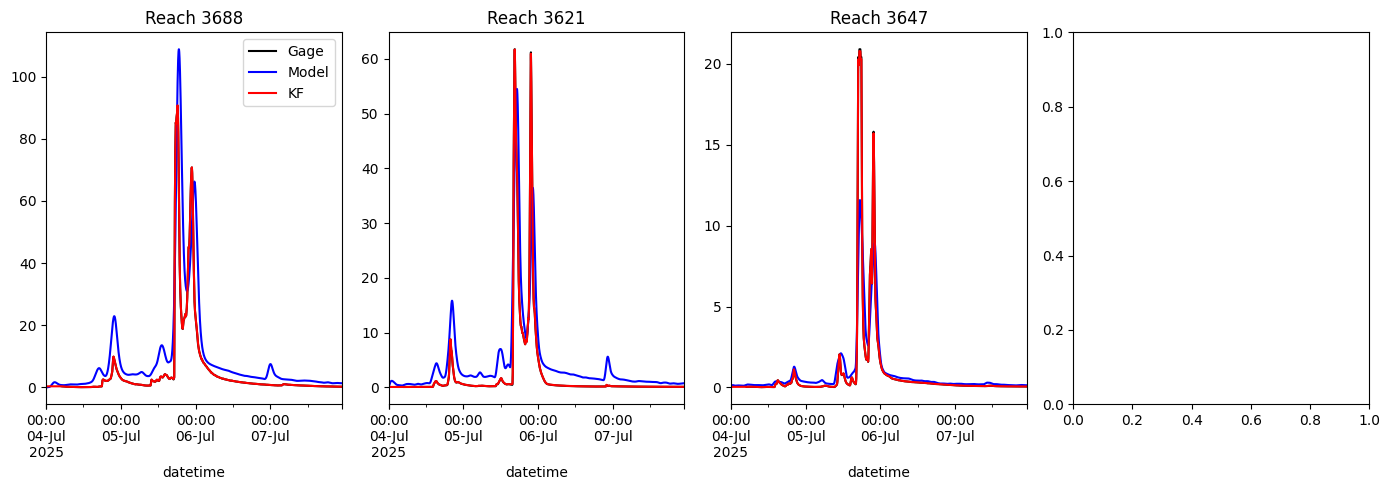

In [812]:
fig, ax = plt.subplots(1, 4, figsize=(14, 5))

for index, reach_id in enumerate(measurements.columns):
    measurements[reach_id].plot(ax=ax.flat[index], c='k', label='Gage')
    outputs_noda[reach_id].plot(ax=ax.flat[index], c='b', label='Model')
    outputs_da[reach_id].plot(ax=ax.flat[index], c='r', label='KF')
    if index < measurements.columns.size - 3:
        ax.flat[index].xaxis.set_ticklabels([])
    ax.flat[index].xaxis.set_ticklabels([], minor=True)
    ax.flat[index].set_title(f'Reach {reach_id}')
ax.flat[0].legend()
plt.tight_layout()

### Plot DA result vs. NODA result at gage locations

(0.0, 250.0)

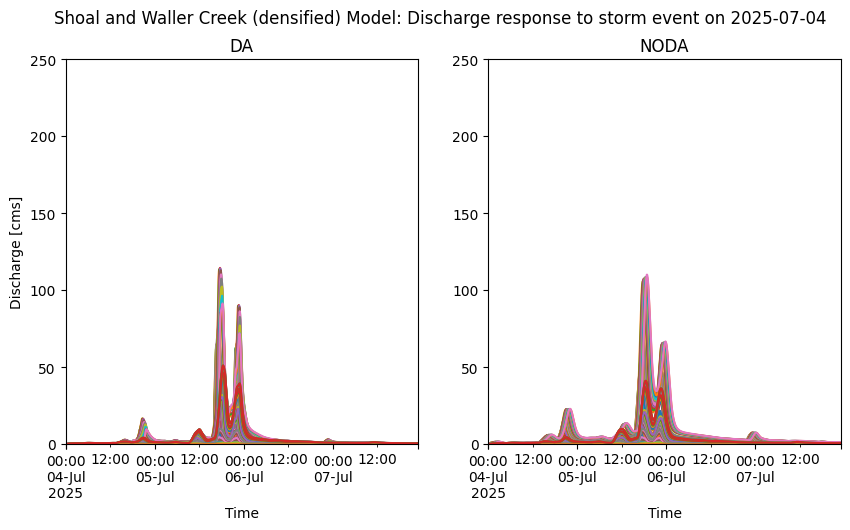

In [813]:
# Plot model output data 
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex = True)
outputs_da.plot(ax=ax, legend=False)
outputs_noda.plot(ax=ax1, legend=False)
ax.set_title("DA")
ax1.set_title("NODA")
ax.set_xlabel('Time')
ax1.set_xlabel('Time')
ax.set_ylabel('Discharge [cms]')
fig.suptitle(ws_string + ' Model: Discharge response to storm event on ' + startdate_string)
ax.set_ylim(0,250)
ax1.set_ylim(0,250)
# plt.legend()

### Plot map of gains

In [814]:
total_gain = (outputs_da - outputs_noda).mean(axis=0)
# input_columns

In [815]:
if input_path == '../../DensiFIMcation/data/shoal_waller_nwm_partitioned.json': 
    den_streams_tx = gpd.read_file('../../densifimcation_shared/data/nwm_streams_tx')
    den_streams_tx['ID'] = den_streams_tx['ID'].astype(int).astype(str)
    den_streams_travis = den_streams_tx[den_streams_tx['ID'].isin(input_columns)].copy()
    den_streams_travis['gain'] = den_streams_travis['ID'].map(total_gain).fillna(0.).values
    den_streams_travis['log_gain'] = np.log(1 + np.abs(den_streams_travis['gain'].values))

elif input_path == '../../DensiFIMcation/data/shoal_waller_less_densified_partitioned.json': 
    den_streams_tx = gpd.read_file('../../DensiFIMcation/data/ESRI_streamlines_trimmed')
    den_streams_tx['ID'] = den_streams_tx['GridID'].astype(int).astype(str)
    den_streams_travis = den_streams_tx[den_streams_tx['ID'].isin(input_columns)].copy()
    den_streams_travis['gain'] = den_streams_travis['ID'].map(total_gain).fillna(0.).values
    den_streams_travis['log_gain'] = np.log(1 + np.abs(den_streams_travis['gain'].values))

elif input_path == '../../densifimcation_shared/data/shoal_densified.json': 
    den_streams_tx = gpd.read_file('../../cuahsi-summer-institute-2025/data/travis_densified_streamlines')

den_streams_tx.head()

,arcid,GridID,Shape_Leng,OrigLength,SplitID,HydroID,From_Node,To_Node,NextDownID,PU_Order,DrainID,LengthKM,geometry,ID
0,1,3578,539.037192,539.037192,3520,3578,1,2,3579,1,3790,0.164299,"LINESTRING (3114586.237 10111960.846, 3114591....",3578
1,3,3579,908.957019,908.957019,3522,3579,2,3,3602,4,3791,0.277051,"LINESTRING (3115041.819 10111916.668, 3115047....",3579
2,7,3580,1734.160458,1734.160458,3526,3580,4,5,3613,7,3792,0.528573,"LINESTRING (3115226.26 10107712.063, 3115226.2...",3580
3,13,3581,1415.009603,1415.009603,3532,3581,6,7,3621,10,3793,0.431296,"LINESTRING (3114590.102 10103429.042, 3114590....",3581
4,29,3582,2097.934781,2097.934781,3548,3582,8,9,3665,1,3794,0.639452,"LINESTRING (3118244.144 10083148.197, 3118245....",3582


In [816]:
num_sec = str(int(model_collection.timedelta.total_seconds()))
print((num_sec))

20


In [817]:
# Compare maximum modeled streamflow value across all reaches for DA and NODA runs 
print('No DA: ' + str(round(outputs_noda.max().max(), 3)))
print('DA: ' + str(round(outputs_da.max().max(), 3)))

No DA: 110.216
DA: 114.556


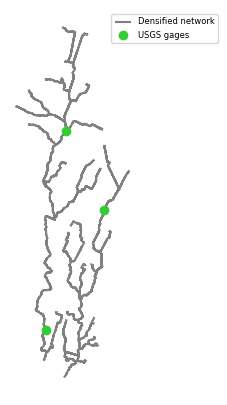

In [818]:
swsites = TCsites[0]
swsites = swsites.to_crs(den_streams_travis.crs)
# missingsite = swsites[swsites.site_no == '08157560']

fig, ax = plt.subplots(figsize = (5,5))
den_streams_travis.plot(ax = ax, color = 'gray', zorder = 1, label = 'Densified network')
swsites.plot(ax = ax, c = 'limegreen', zorder = 10, label = 'USGS gages')
# missingsite.plot(ax = ax, c = 'red', zorder = 15, label = 'Missing gage')
ax.axis('off')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.7, 1), prop={'size': 6})

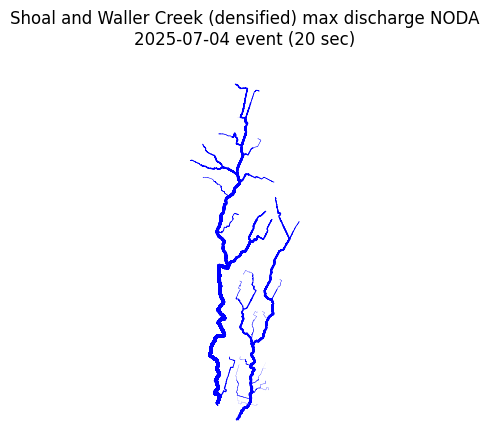

In [819]:
# take output from current time step and plot on the densified national water model stream network
fig, ax = plt.subplots()
den_streams_travis['flow'] = den_streams_travis['ID'].map(outputs_noda.max(axis=0)).fillna(0.).values
den_streams_travis.plot(ax=ax, color='b', zorder=3, 
                        linewidth=0.5*np.log(1 + den_streams_travis['flow'].values))
plt.title(ws_string + " max discharge NODA\n" + startdate_string + " event (" + num_sec + " sec)")
_ = plt.axis('off')
# plt.savefig('../figures/MaxDischarge_NODA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

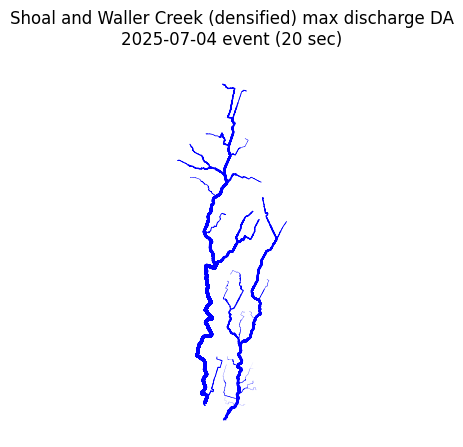

In [820]:
# take output from current time step and plot on the densified national water model stream network
fig, ax = plt.subplots()
den_streams_travis['flow'] = den_streams_travis['ID'].map(outputs_da.max(axis=0)).fillna(0.).values
den_streams_travis.plot(ax=ax, zorder=3, color = 'blue', legend=True, 
                        linewidth=0.5*np.log(1 + den_streams_travis['flow'].values), label = 'Flows (cms)')
plt.title(ws_string + " max discharge DA\n" + startdate_string + " event (" + num_sec + " sec)")
_ = plt.axis('off')
# plt.savefig('../figures/MaxDischarge_DA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

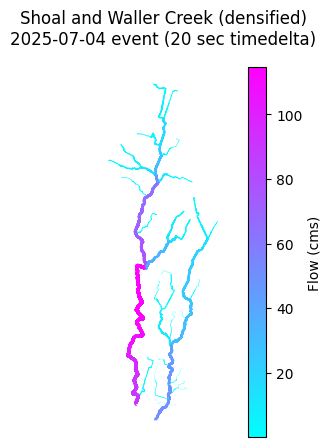

In [821]:
fig, ax = plt.subplots()
den_streams_travis['flow'] = den_streams_travis['ID'].map(outputs_da.max(axis=0)).fillna(0.).values
den_streams_travis.plot(column='flow', cmap='cool', legend=False, ax = ax, linewidth=0.5*np.log(1 + den_streams_travis['flow'].values), label = 'Flows (cms)')
# swsites[swsites.site_no != '08157560'].plot(c = 'red', marker = '^', ax = ax)
plt.title(ws_string + "\n" + startdate_string + " event (" + num_sec + " sec timedelta)")
_ = plt.axis('off')

# Legend creation code from chatgpt 
# Get the colorbar (GeoPandas uses matplotlib's ScalarMappable behind the scenes)
sm = plt.cm.ScalarMappable(
    cmap='cool',
    norm=plt.Normalize(
        vmin=den_streams_travis['flow'].min(),
        vmax=den_streams_travis['flow'].max()
    )
)
sm._A = []  # Trick to allow colorbar creation without associated image
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Flow (cms)')  

# plt.savefig('../figures/MeanDifferenceDA_NODA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

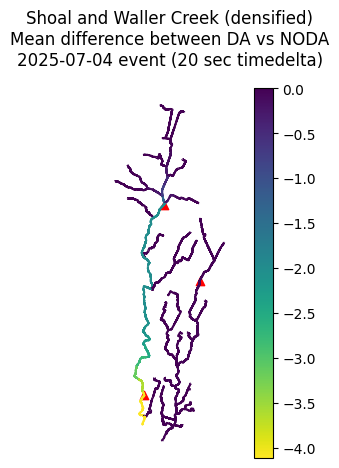

In [822]:
fig, ax = plt.subplots()
den_streams_travis.plot(column='gain', cmap='viridis_r', legend=True, ax = ax)
swsites[swsites.site_no != '08157560'].plot(c = 'red', marker = '^', ax = ax)
plt.title(ws_string + "\nMean difference between DA vs NODA\n" + startdate_string + " event (" + num_sec + " sec timedelta)")
_ = plt.axis('off')
# plt.savefig('../figures/MeanDifferenceDA_NODA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

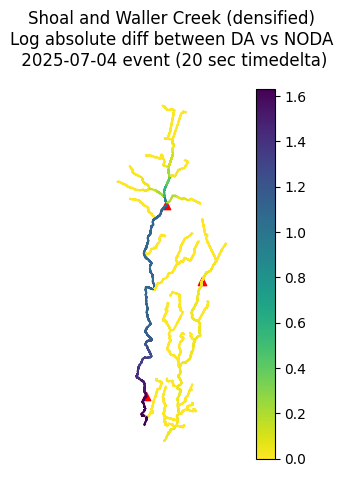

In [823]:
fig, ax = plt.subplots()
den_streams_travis.plot(column='log_gain', cmap='viridis_r', legend=True, ax = ax)
swsites[swsites.site_no != '08157560'].plot(c = 'red', marker = '^', ax = ax)
plt.title(ws_string + "\nLog absolute diff between DA vs NODA\n " + startdate_string + " event (" + num_sec + " sec timedelta)")
_ = plt.axis('off')
# plt.savefig('../figures/LogAbsoluteDifferenceDA_NODA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

# Export peak flow data to csv 

In [824]:
# Organize and export model ouput data 
outputs = pd.concat([pd.DataFrame(outputs_da.max(), columns = ['q_cfs_da']), pd.DataFrame(outputs_noda.max(), columns = ['q_cfs_no_da'])], axis = 1)
outputs.index = outputs.index.astype(int)
outputs.index.name = 'ID'
print(outputs.index.name)
outputs = outputs * 35.314684921034 # convert back to cfs for ESRI geoprocessing 
# Save csv 
outputs.to_csv('../../DensiFIMcation/data/less_densified_model_qpeak_' + num_sec + 'sec_' + startdate + '_' + ws + '.csv')

ID


In [825]:
# Read csv output 
outputs = pd.read_csv('../../DensiFIMcation/data/less_densified_model_qpeak_' + num_sec + 'sec_' + startdate + '_' + ws + '.csv')
print(outputs)

       ID     q_cfs_da  q_cfs_no_da
0    3578     3.142572     3.142572
1    3579   282.517332   281.486297
2    3580   819.919979   867.775881
3    3581  1696.159629  1544.288278
4    3594   147.634833   147.626313
..    ...          ...          ...
119  3697     4.298533     4.298533
120  3698     9.764251     9.764251
121  3700     5.314765     5.314765
122  3705  1807.343131  1456.561546
123  3706  1807.343131  1456.561546

[124 rows x 3 columns]
